### DESCRIPTION

Identify the level of income qualification needed for the families in Latin America.

Problem Statement Scenario:
Many social programs have a hard time ensuring that the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of the population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to
classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB)believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

In [1]:
# Let us import all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import plot_confusion_matrix,accuracy_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data

data = pd.read_csv('train.csv',index_col=0)

In [3]:
#Displaying top 5 rows of data

data.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
Id,,,,,,,,,,,,,,,,,,,,,
ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


### Data Wrangling and Missing Value Treatment
Let us explore and clean up the raw data for further analysis.

In [4]:
#Checking shape of training set

data.shape

(9557, 142)

In [5]:
#Identify the output variable.

data['Target'].unique()

array([4, 2, 3, 1], dtype=int64)

The task of the project is to predict poverty level and the 'Target' column contains that information. It contains 4 unique levels of poverty, 4 representing non vulnerable households and 1 representing people in extreme poverty. Hence it is the output variable.

In [6]:
#Understand the type of data

dtypes = data.columns.to_series().groupby(data.dtypes).groups
dtypes

{dtype('int64'): Index(['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2',
        'r4h3', 'r4m1',
        ...
        'area1', 'area2', 'age', 'SQBescolari', 'SQBage', 'SQBhogar_total',
        'SQBedjefe', 'SQBhogar_nin', 'agesq', 'Target'],
       dtype='object', length=130),
 dtype('float64'): Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'overcrowding',
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned'],
       dtype='object'),
 dtype('O'): Index(['idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')}

We see that the columns are of 3 data types- int, float and object. Furthermore, the features can be categorized depending on their level:
1. Household level data, containing features which are common for the household such as monthly rent, quality of walls etc.
2. Individual level data, pertaining to each individual such as whether they are the head of household, years of education etc.
3. Identifier data, unique for each individual and household.

In [7]:
#Check if there are any biases in your dataset.

data.Target.value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

We see that various poverty levels are unequally distributed, level 4 having the highest number of people and level 1 the least. Hence dataset is biased. We don't know if this is an accurate representation of the population, however it seems reasonable to assume that only a small portion of population is in extreme to moderate poverty.

In [8]:
# Check whether all members of the house have the same poverty level.
# We will check the number of unique target values that are present for each household. If it is more than 1, data needs to be treated.

data_house = data.groupby('idhogar')
i=0
wlevel=[]
for group, frame in data_house:
    if len(set(frame['Target'])) != 1:
        wlevel.append(group)
        i+=1
print('Number of households where all members do not have same poverty level', i)

Number of households where all members do not have same poverty level 85


In [9]:
# Check if there is a house without a family head.

j=0
whead=[]
for group, frame in data_house:
    if 1 not in list(frame['parentesco1']):
        whead.append(group)
        j+=1
print('Number of households without a family head', j)

Number of households without a family head 15


In [10]:
# Set poverty level of the members and the head of the house within a family.

for id in wlevel:
    val = int(data[(data['idhogar']==id) & (data['parentesco1']==1)]['Target'])
    data.loc[data['idhogar'] == id, 'Target'] = val

We have set the poverty level of each member same as the head of the family as he/she is a representative of the house. Now the above code is only for families which have a head. Let us see whether any household without a head has unequal levels within the family.

In [11]:
whead in wlevel

False

Hence poverty level has been set for all households.

In [12]:
# Count how many null values are existing in columns.

missing_data = pd.Series(data.isnull().sum())
missing_data[missing_data != 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

There are many missing values in the dataset.

'v2a1' represents monthly rent payment. Now we have features indicating ownership of house, so it is possible that people with null value in rent actually own the house.

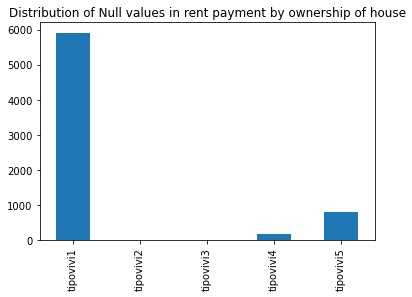

In [13]:
#We will create a list of features indicating house ownership
own = [x for x in data.columns if x[:7]=='tipoviv']

# Plot of the house ownership variables wrt missing rent payments
data.loc[data['v2a1'].isnull(), own].sum().plot(kind ='bar',title='Distribution of Null values in rent payment by ownership of house')

Most of the null values belong to people who own a house. Hence we will set their rent payment to 0. We will impute the median for the rest.

In [14]:
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

'v18q1' represents number of tablets owned by household. Let us see if it has any relation with the variable 'v18q' which represents whether a person owns a tablet or not.

In [15]:
data.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    7342
1       0
Name: v18q1, dtype: int64

This shows that null values in 'v18q1' exist only for people who dont own a tablet. Hence we can fill those null values with 0 as no one in the household owns a tablet.

In [16]:
data['v18q1'] = data['v18q1'].fillna(0)

'rez_esc' represents years behind in school. Now we can fill this value with 0 for people who are below 7 or above 19 years of age, as they are not in school. For the rest, we will impute using median.

In [17]:
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

Now for 'meaneduc' and its squared, we will impute it with median.

Now lets convert some object features into numeric. It is given in description that yes:1 and no:0.

In [18]:
data[['dependency', 'edjefe', 'edjefa']]

,dependency,edjefe,edjefa
Id,,,
ID_279628684,no,10,no
ID_f29eb3ddd,8,12,no
ID_68de51c94,8,no,11
ID_d671db89c,yes,11,no
ID_d56d6f5f5,yes,11,no
...,...,...,...
ID_d45ae367d,.25,9,no
ID_c94744e07,.25,9,no
ID_85fc658f8,.25,9,no


In [19]:
data['dependency'].replace({'yes':1,'no':0},inplace=True)
data['edjefe'].replace({'yes':1,'no':0},inplace=True)
data['edjefa'].replace({'yes':1,'no':0},inplace=True)

### Exploratory Data Analysis
Now let us do some bivariate analysis of input features with the Target variable. Let us first plot the distribution of numeric continuous variables with the Target.

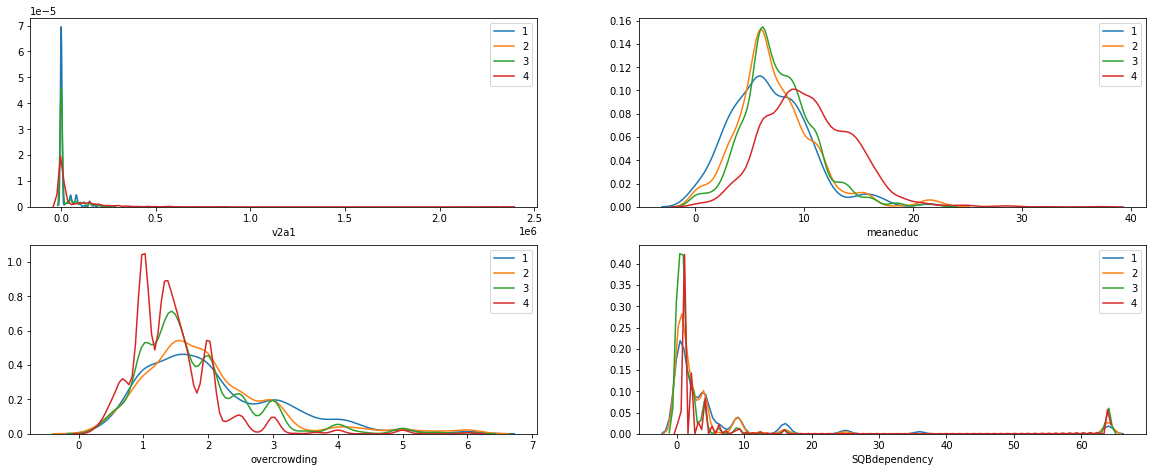

In [20]:
cols = ['v2a1','meaneduc','overcrowding','SQBdependency']
plt.figure(figsize = (20, 16))
for i, col in enumerate(cols):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for j in range(1,5):
        # Plot each poverty level as a separate line
        sns.kdeplot(data.loc[data['Target'] == j, col],label=j)
        plt.xlabel(col)

We have some interesting observations such as, people in poorer households have more number of people per room, and average education on non vulnerable people is higher. Let us now check distribution of some categorical/discrete variables.

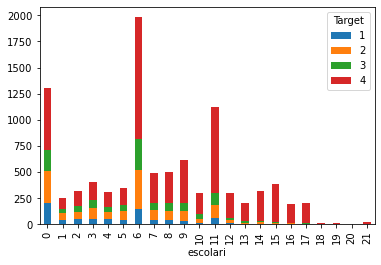

In [21]:
# Distribution of Number of years of schooling vs poverty level
pd.crosstab(data['escolari'], data['Target']).plot(kind='bar', stacked=True) 

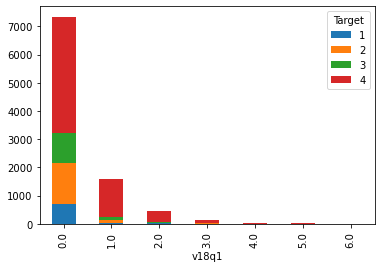

In [22]:
# DIstribution of number of tablets owned vs poverty
pd.crosstab(data['v18q1'], data['Target']).plot(kind='bar', stacked=True) 

We see that higher poverty level corresponds to lesser years of education and lesser items owned in general. Now let us try to create new meaningful features and combine redundant ones.

### Feature Engineering
Now before fitting the model, we need to do some feature engineering. We will:
1. Remove redundant variables
2. Create new features
3. Combine individual level features to form single feature for a household
4. Impute missing values

There are several variables which are redundant:
1. Squared variables which are just squares of other features. Since we are using random forest, we dont need polynomial features, hence we will remove them.
2. Several variables representing size of the household.

In [23]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

data = data.drop(columns=sqr_)
data = data.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

We have features representing quality of walls, roof and floor. They have a natural ordering (bad<neutral<good). So we can create an ordinal variable combining these columns.
Similarly, we can combine education levels columns to create a single feature representing highest education level.

In [24]:
data['walls'] = np.argmax(np.array(data[['epared1', 'epared2', 'epared3']]),axis = 1)
data = data.drop(columns = ['epared1', 'epared2', 'epared3'])
data['roof'] = np.argmax(np.array(data[['etecho1', 'etecho2', 'etecho3']]),axis = 1)
data = data.drop(columns = ['etecho1', 'etecho2', 'etecho3'])
data['floor'] = np.argmax(np.array(data[['eviv1', 'eviv2', 'eviv3']]),axis = 1)
data = data.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

In [25]:
instlevel = [c for c in data.columns if (c[:9]=='instlevel')]
data['inst'] = np.argmax(np.array(data[instlevel]), axis = 1)
data = data.drop(columns = instlevel)

Now there are various individual level features which can be aggregated so that we get a single value for each household. This will make sure that we get a single prediction per household.

In [26]:
#Features representing individual household levels
indcol = ['idhogar','v18q','male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7','parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5','parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10','parentesco11', 'parentesco12', 'inst', 'mobilephone','rez_esc', 'escolari', 'age']
ind = data[indcol]

#Aggregating the features
agg = ind.groupby('idhogar').agg(['min','max','sum','std','count'])
newcol = []
for i in agg.columns.levels[0]:
    for j in agg.columns.levels[1]:
        newcol.append(f'{i}-{j}')
agg.columns = newcol

In [27]:
#Household level features
housecol = list(set(data.columns)-set(indcol))
housecol.append('idhogar')

#Selecting only data about head of household
house = data[data['parentesco1']==1][housecol]

#Merging individual and household level features
train = house.merge(agg, on = 'idhogar', how = 'left')
train

,floor,pisomadera,sanitario6,abastaguadentro,sanitario2,bedrooms,paredblolad,walls,elimbasu1,r4h1,...,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-count,age-min,age-max,age-sum,age-std,age-count
0,0,0,0,1,1,1,1,1,1,0,...,10,10,10,NaN,1,43,43,43,NaN,1
1,1,1,0,1,1,1,0,1,1,0,...,12,12,12,NaN,1,67,67,67,NaN,1
2,2,0,0,1,1,2,0,1,1,0,...,11,11,11,NaN,1,92,92,92,NaN,1
3,2,0,0,1,1,3,1,2,1,0,...,2,11,33,4.272002,4,8,38,100,14.899664,4
4,1,0,0,1,1,1,1,0,1,0,...,0,11,23,5.123475,4,7,30,76,11.690452,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,1,0,0,0,1,2,0,1,0,1,...,0,5,9,2.489980,5,6,29,75,11.489125,5
2969,1,1,0,0,0,2,0,1,0,2,...,0,6,17,2.607681,5,2,40,98,16.133815,5
2970,1,0,0,1,0,3,0,1,1,1,...,0,11,30,5.049752,5,2,46,134,18.753666,5
2971,2,0,0,1,0,1,1,2,0,0,...,0,6,6,4.242641,2,61,67,128,4.242641,2


### Model Building

We will be using cross validation score for comparing models hence no need to have a single hold out test set. After transforming the data, we will build several models and compare their performance based on AUC score.

In [28]:
#Splitting data into input and target sets
train_y = train['Target']
train_x = train.drop(columns = ['idhogar', 'Target'])

In [29]:
corr_matrix = train_x.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

train_x = train_x.drop(columns=to_drop)

print(train_x.shape)
features=train_x.columns

There are 64 correlated columns to remove.
(2973, 158)


In [30]:
#Let us normalize the data and impute missing values

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')),('scaler', StandardScaler())])
train_x = pipeline.fit_transform(train_x)

Let us check the cross validation scores of various models and choose the best based on AUC score.

In [31]:
model_score = dict()
model_score['Logistic Regression'] = cross_val_score(LogisticRegressionCV(),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['SVM'] = cross_val_score(LinearSVC(),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['Naive Bayes'] = cross_val_score(GaussianNB(),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['Random Forest'] = cross_val_score(RandomForestClassifier(bootstrap=True,oob_score=True),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['Extra Trees'] = cross_val_score(ExtraTreesClassifier(bootstrap=True,oob_score=True),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['Gradient Boosting'] = cross_val_score(GradientBoostingClassifier(),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['XGBoost'] = cross_val_score(XGBClassifier(),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()
model_score['Neural Network'] = cross_val_score(MLPClassifier(),train_x,train_y,cv=5,n_jobs=-1,scoring='f1_macro').mean()

In [32]:
for i,j in model_score.items():
    print('Cross validation F1 score of ',i,' is ',j)

Cross validation F1 score of  Logistic Regression  is  0.25465932632316995
Cross validation F1 score of  SVM  is  0.25133162192264197
Cross validation F1 score of  Naive Bayes  is  0.1246756282225165
Cross validation F1 score of  Random Forest  is  0.33076167789575067
Cross validation F1 score of  Extra Trees  is  0.2990422124376672
Cross validation F1 score of  Gradient Boosting  is  0.2807764526413222
Cross validation F1 score of  XGBoost  is  0.30325905798285324
Cross validation F1 score of  Neural Network  is  0.28179371891963034


We can directly reject Logistic regression, SVM and Naive Bayes. With hyperparameter tuning, neural network, extra trees and Gradient boosting might give better results. However we will choose random forest and XGBoost and analyse the confusion matrix further.

In [33]:
#Splitting data into train and test set to analyse performance on test set

x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.3,random_state=42)

We will look at Random Forest first. Let us do hyperparameter tuning on training set and analyse results on test set. We don't need a separate validation set as oob scores of Random Forest act as a validation set.

In [34]:
rf = RandomForestClassifier(bootstrap=True,oob_score=True)
param_grid = {'n_estimators': [200,400,600,800,1000],'min_samples_leaf':[1,5,10],'max_depth':[10,20,30,40,50,70,100]}
best_score=0
for g in ParameterGrid(param_grid):
    rf.set_params(**g)
    rf.fit(x_train,y_train)
    # save if best
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_grid = g

print("OOB: %0.5f" % best_score) 
print("Grid:", best_grid)

OOB: 0.68621
Grid: {'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 400}


Now we will fit RF model with tuned parameters and check accuracy and F1 score.

Accuracy of train data  0.7900048053820279
Accuracy of test data  0.6883408071748879
F1 score of test data  0.3642439615820262


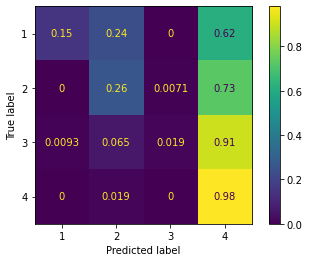

In [35]:
rfc = RandomForestClassifier(bootstrap=True,oob_score=True,max_depth=70,min_samples_leaf=5,n_estimators=400)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
plot_confusion_matrix(rfc,x_test,y_test,normalize='true')

x_pred=rfc.predict(x_train)
print('Accuracy of train data ',accuracy_score(x_pred,y_train))

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of test data ',accuracy)

f1= f1_score(y_test,y_pred,average='macro')
print('F1 score of test data ',f1)


We see that the F1 score has improved after parameter tuning. Also, gap between training accuracy and test accuracy is less, which suggests model is not significantly overfitting.

Now we will tune parameters of XGBoost using cross validation and calculate metrics on the same train and test sets.

In [37]:
xg = XGBClassifier()
param_grid = {'n_estimators': [800,900,1000],'max_depth':[5,10,15],'learning_rate':[0.01,0.1,0.2]}
xgc = GridSearchCV(xg,param_grid = param_grid, cv=3,scoring='f1_macro')
xgc.fit(x_train,y_train)
xgc.best_params_

[21:23:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[21:31:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[21:36:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 900}

[22:09:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of training data  1.0
Accuracy of test data  0.6659192825112108
F1 score of test data  0.4239419257388206


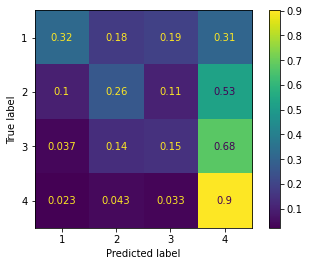

In [38]:
xg = XGBClassifier(learning_rate=0.1,max_depth=5,n_estimators=900)
xg.fit(x_train, y_train)

y_pred = xg.predict(x_test)
plot_confusion_matrix(xg,x_test,y_test,normalize='true')

x_pred=xg.predict(x_train)
print('Accuracy of training data ',accuracy_score(x_pred,y_train))

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of test data ',accuracy)

f1= f1_score(y_test,y_pred,average='macro')
print('F1 score of test data ',f1)

We see that F1 score of XGBoost has significantly improved after parameter tuning and is much better than all other models. Hence, we will choose this model. Prediction of poverty levels can be improved using this. Collecting more data will also be helpful.